<a href="https://colab.research.google.com/github/OleBo/candy-power-ranking/blob/master/Exploring_and_visualizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring and visualizing the Candy Power data set
Presumably, this is a brand new dataset we've never seen before, and we need to figure out what we actually have in this dataset. If we think about our goal, our goal here is to, given attributes about a product, trying to determine the winning score. So, number one, this means it's going to be a regression problem. So, we're trying to figure out, we're trying to analyze the winpercent value. So, let's think more about the goal that we're trying to do, we're trying to predict the winning score.







## Setting up our workspace

Before we go on, let's make sure we set up our workspace. We'll need to import in the libraries and data we're going to use.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)#!pip install plotly==4.1.0
import plotly

# read data from local file (offline use)
url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv'
#!wget 'https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv'
if os.path.exists("candy-data.csv"): 
    print("using local file")
    url = "candy-data.csv"
    
nRowsRead = 1000 # specify 'None' if want to read whole file
df = pd.read_csv(url, delimiter=',', nrows = nRowsRead)
df.dataframeName = 'candy-data.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

using local file
There are 85 rows and 13 columns


The first step we want to do before we even dive into model building is, make sure we understand the data. One thing that you will notice is that, this is a relatively small dataset. So, it's definitely going to fit into our local instance. 
We read the cvs file and return the result back as a pandas dataframe. So if you look at this, we can df.head, which returns the first five results, and we can analyze them right here. 

In [2]:
df.head(5)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


## Code

So, what we can do is, we can create a generalized function to query columns of interests that we want. If you think about it, there's a couple of key things that we're interested in. Number one, we're interested in, for each value of that column, what is the count as in the number of products? What is the average winpercent for that column value? This will become more apparent. But this is an example query that you could use to analyze your data set, and we'll use the string formatting function which allows us basically said, "Given this column name plug this into the SQL query." So, whenever we call get distinct values, we'll get two fields of interests: The count and the average winpercent.

In [3]:
# Create a function that finds the number of records and the average winpercent
!pip install pandasql
import pandasql as ps
import pandas as pd
def get_distinct_values(column_name):
  url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv'
  df = pd.read_csv(url, index_col=0)
  sql = """
SELECT
  {0},
  COUNT(1) AS num_products,
  AVG(winpercent) AS avg_winpercent
FROM 
  df
GROUP BY
  {0}
  """.format(column_name)
  return ps.sqldf(sql, locals())

print(get_distinct_values("chocolate"))

   chocolate  num_products  avg_winpercent
0          0            48       42.142257
1          1            37       60.921529


### Distribution graphs (histogram/bar graph) of sampled columns:

In [4]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

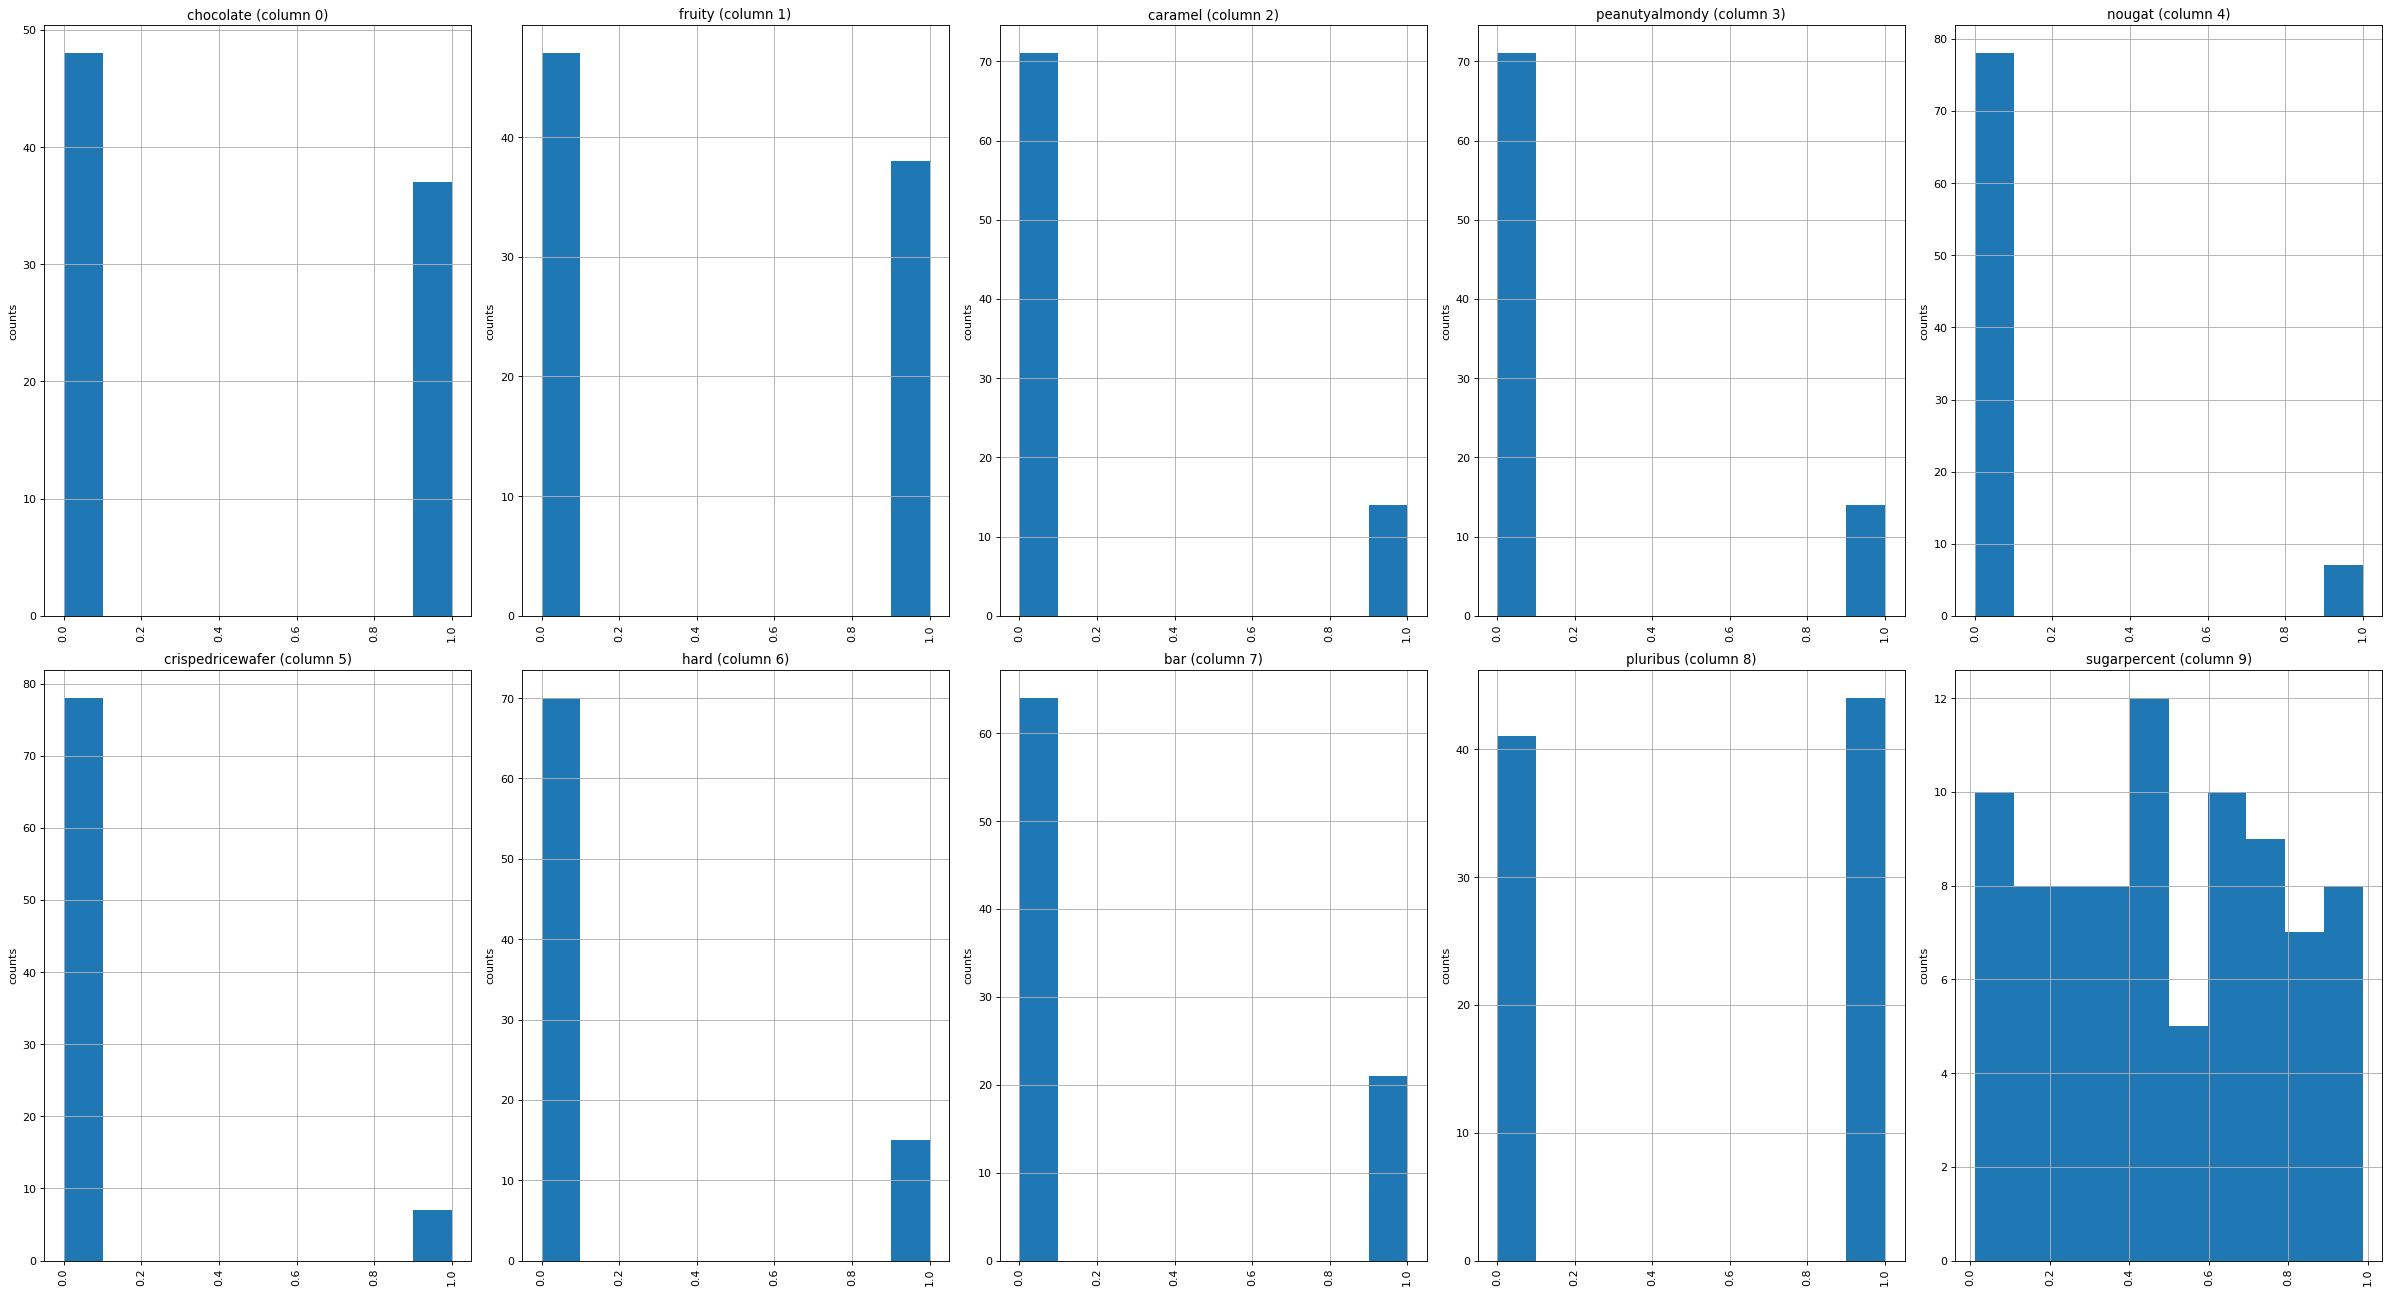

In [5]:
plotPerColumnDistribution(df, 10, 5)

### Correlation matrix:

In [6]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

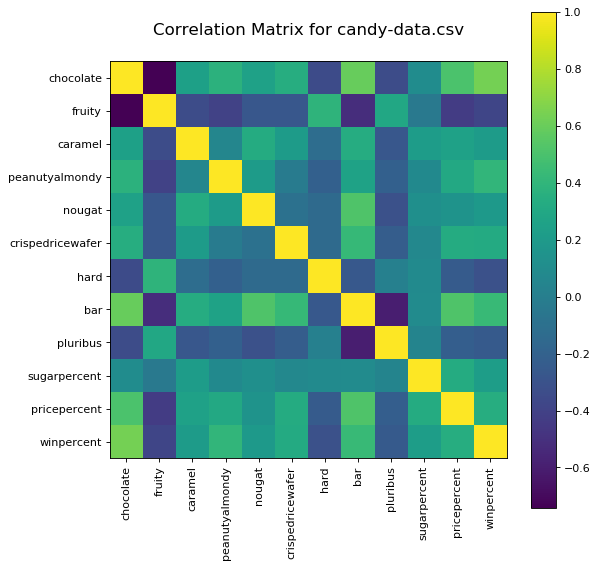

In [7]:
plotCorrelationMatrix(df, 8)

In [8]:
### Scatter and density plots:

In [9]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

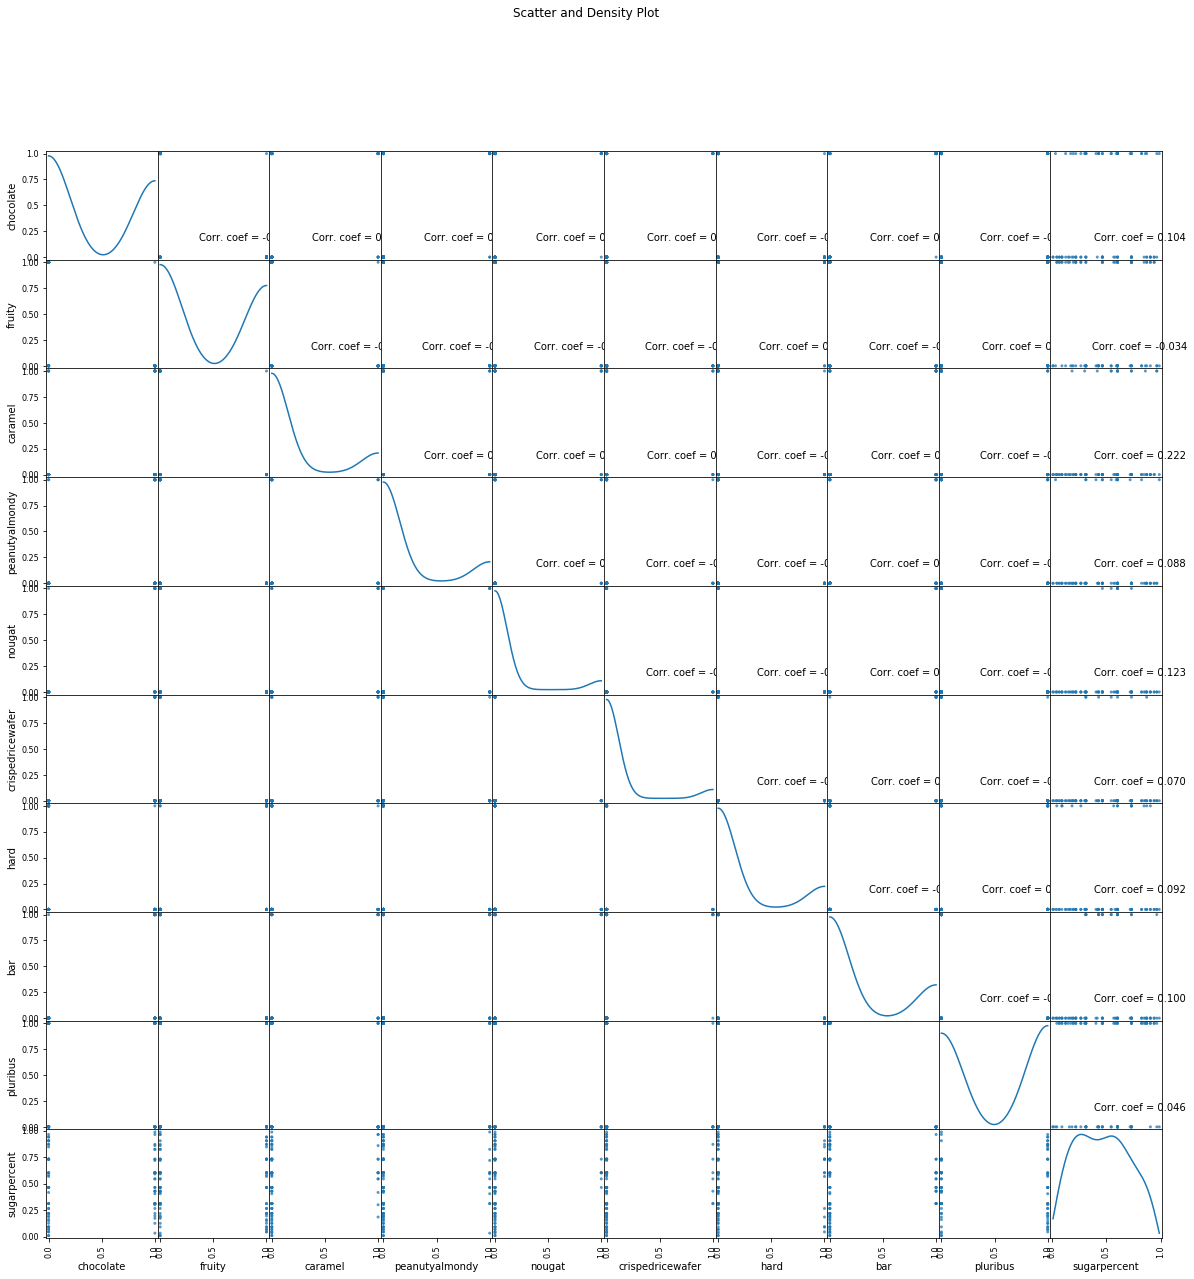

In [10]:
plotScatterMatrix(df, 20, 10)

### plotly table

go.Table provides a Table object for detailed data viewing. The data are arranged in a grid of rows and columns. Most styling can be specified for header, columns, rows or individual cells. Table is using a column-major order, ie. the grid is represented as a vector of column vectors.

In [33]:
import plotly.graph_objects as go

df.sort_values(by='winpercent', ascending=False, inplace=True)

fig = go.Figure(data=[go.Table(
    header=dict(values=[df.index.name,df.winpercent.name],
                fill_color='paleturquoise',
                align='left'
               ),
    cells=dict(values=[df.index,df.winpercent],
               fill_color='lavender',
               align='left'
              ))
])

fig.show()

## Bar Plot

> great if you're looking at something that belongs to a certain group or not (categorical data)

In this dataset, we have a lot of information about qualities each candy has. Does it contain chocolate? Is it fruit flavored? Is there caramel in the candy? These are what are calling categorical variables, because a given candy candy belongs to one specific category. 

So here, we have a bar plot to see the products containing chocolate. Here, let's call the distinct values code. We already have the result, but I'm going to call it again so we can visualize it.

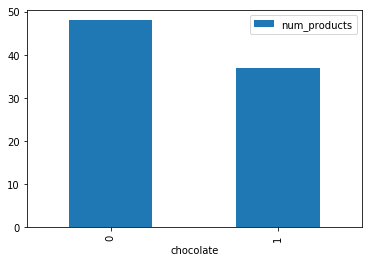

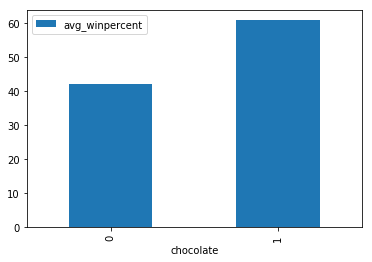

In [12]:
# Bar plot to see chocolate with num_products and avg_winpercent
get_distinct_values("chocolate").plot(x="chocolate", y="num_products", kind="bar")
get_distinct_values("chocolate").plot(x="chocolate", y="avg_winpercent", kind="bar")

What we can see is, we can look at the count which is the y axis by chocolate. So, in this case chocolate 0, you can see there's a slight difference here in terms of the count, but what we're also more interested in, is there a difference in the winning score of the product, right? Because this is what we're ultimately trying to predict. It looks like there may be some difference, so this is something to definitely note, and it may be something that we want to include in our model. 

So here, we're going to plot the sugarpercent with respect to avg_winpercent. In this case, we're going to actually be making a line plot and the way that we've specified that is it defaults to line plots. But above, we specified that we want to use a bar plot. There's other types that we can plot as well including a bar H for horizontal bar plot as well. I guess as a quick aside, this is using Pandas for plotting, and pandas is a very concise way to plot data, so it's definitely worth getting the handle on. So, let's look at the results of sugarpercent. So again, this is the count. So, you can see start at the most common sugarpercent between .2 and .8 %, which makes intuitive sense as well, but let's see if there's actually a correlation between sugarpercent and winpercent. 

Well, it looks like there is a pretty strong relationship. Now, is this a linear relationship? No, it's not. It's actually a non-linear relationship. So, an increase in sugarpercent may or may not cause an increase in winpercent depending on other columns of interest. 

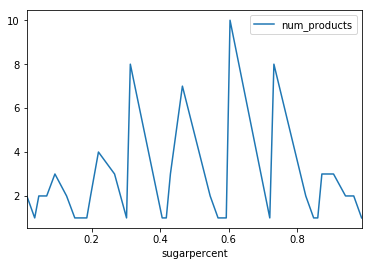

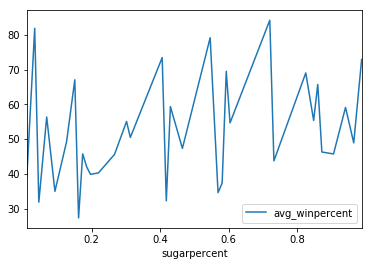

In [13]:
# Line plots to see sugarpercent with avg_winpercent
get_distinct_values("sugarpercent").sort_values("sugarpercent").plot(x="sugarpercent", y="num_products")
get_distinct_values("sugarpercent").sort_values("sugarpercent").plot(x="sugarpercent", y="avg_winpercent")

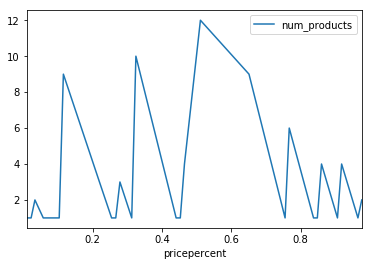

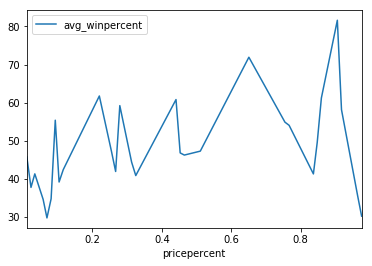

In [14]:
# Line plots to see pricepercent with avg_winpercent
get_distinct_values("pricepercent").sort_values("pricepercent").plot(x="pricepercent", y="num_products")
get_distinct_values("pricepercent").sort_values("pricepercent").plot(x="pricepercent", y="avg_winpercent")

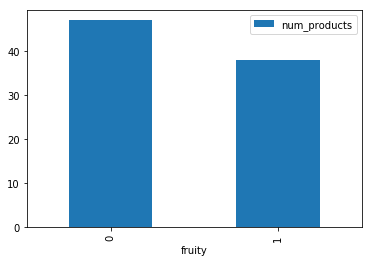

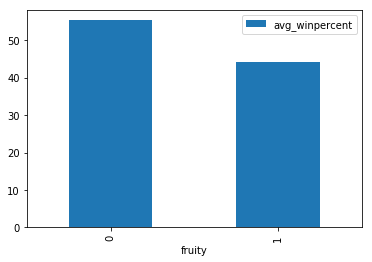

In [15]:
# Bar plot to see fruity with num_products and avg_winpercent
get_distinct_values("fruity").plot(x="fruity", y="num_products", kind="bar")
get_distinct_values("fruity").plot(x="fruity", y="avg_winpercent", kind="bar")

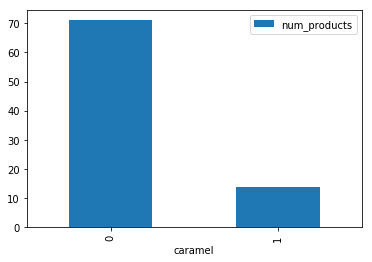

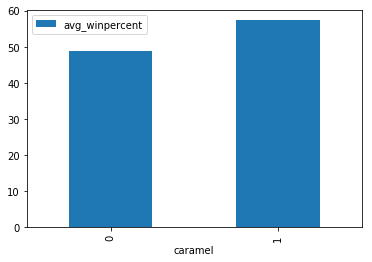

In [16]:
# Bar plot to see caramel with num_products and avg_winpercent
get_distinct_values("caramel").plot(x="caramel", y="num_products", kind="bar")
get_distinct_values("caramel").plot(x="caramel", y="avg_winpercent", kind="bar")

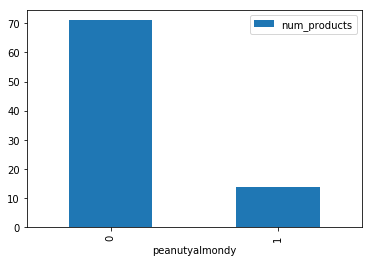

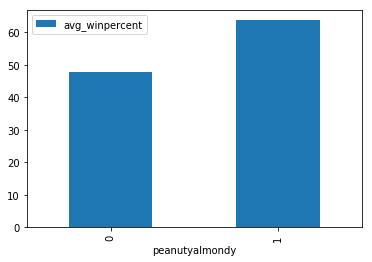

In [17]:
# Bar plot to see peanutyalmondy with num_products and avg_winpercent
get_distinct_values("peanutyalmondy").plot(x="peanutyalmondy", y="num_products", kind="bar")
get_distinct_values("peanutyalmondy").plot(x="peanutyalmondy", y="avg_winpercent", kind="bar")

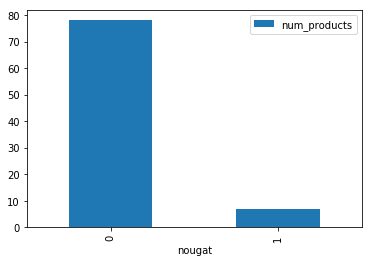

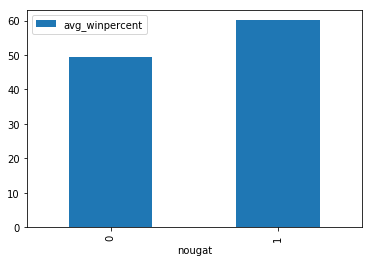

In [18]:
# Bar plot to see nougat with num_products and avg_winpercent
get_distinct_values("nougat").plot(x="nougat", y="num_products", kind="bar")
get_distinct_values("nougat").plot(x="nougat", y="avg_winpercent", kind="bar")

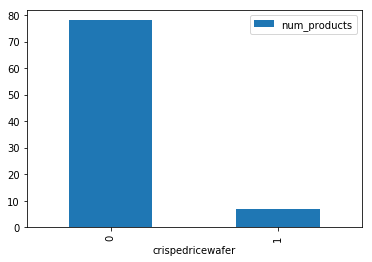

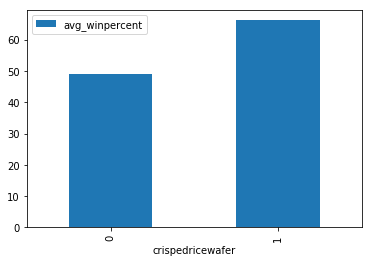

In [19]:
# Bar plot to see crispedricewafer with num_products and avg_winpercent
get_distinct_values("crispedricewafer").plot(x="crispedricewafer", y="num_products", kind="bar")
get_distinct_values("crispedricewafer").plot(x="crispedricewafer", y="avg_winpercent", kind="bar")

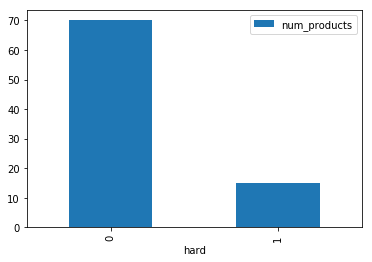

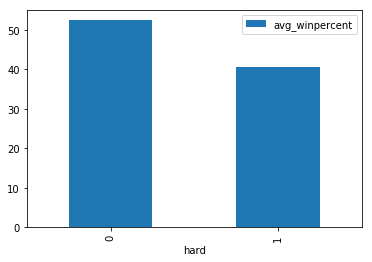

In [20]:
# Bar plot to see hard with num_products and avg_winpercent
get_distinct_values("hard").plot(x="hard", y="num_products", kind="bar")
get_distinct_values("hard").plot(x="hard", y="avg_winpercent", kind="bar")

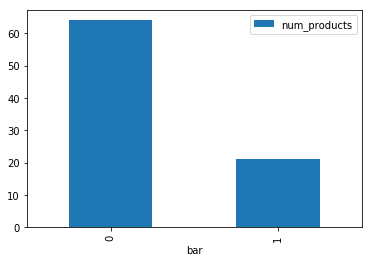

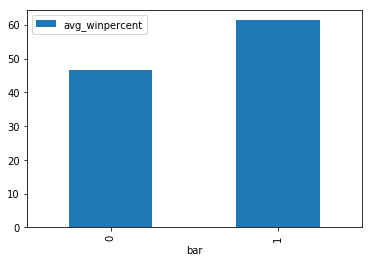

In [21]:
# Bar plot to see bar with num_products and avg_winpercent
get_distinct_values("bar").plot(x="bar", y="num_products", kind="bar")
get_distinct_values("bar").plot(x="bar", y="avg_winpercent", kind="bar")

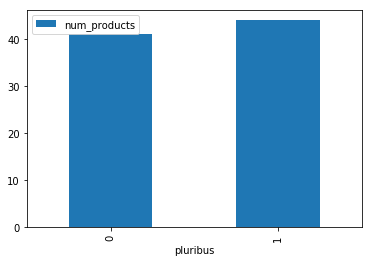

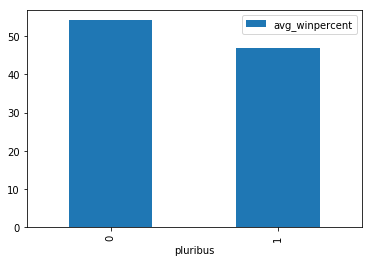

In [22]:
# Bar plot to see pluribus with num_products and avg_winpercent
get_distinct_values("pluribus").plot(x="pluribus", y="num_products", kind="bar")
get_distinct_values("pluribus").plot(x="pluribus", y="avg_winpercent", kind="bar")

Great. All these factors seem to play a part in winpercent. This is encouraging, this is telling us that there's actually some signal in the data, and that now, we're actually ready to move on and start creating our model for the winpercent. 

Next, we will begin our process of creating our dataset for analysis. Key steps here will include data cleansing, feature engineering and creating repeatable samples that we can use for training and evaluating our model.

##Scatter Plot

> great if you're looking at numeric variables

The dataset has information on different candies, including how expensive they are and how much sugar they have in them. One question we can ask using this dataset is whether there is a a relationship between a candy's price and the amount of sugar in it. To see if this is the case, we can use a scatter plot.



(0, 1)

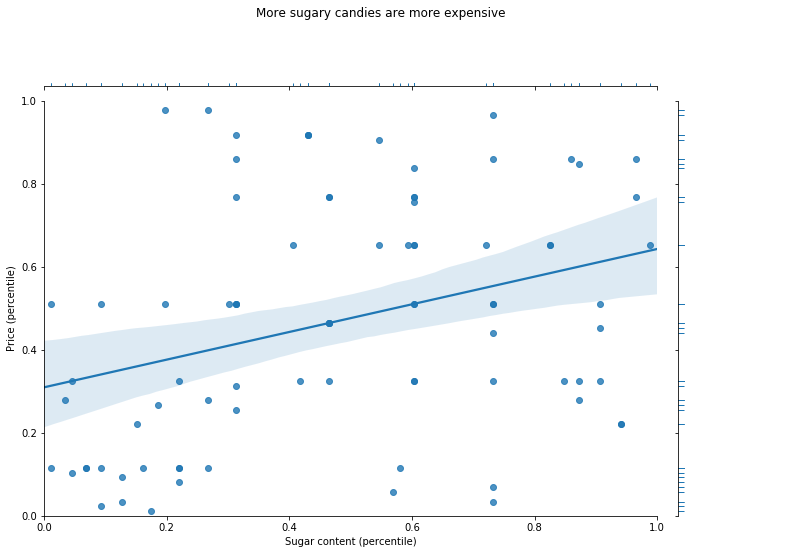

In [23]:
import seaborn as sns
df = pd.read_csv(url)
g = sns.jointplot(x="sugarpercent", y="pricepercent", data=df, kind="reg",
                  marginal_kws=dict(kde=False,hist=False, rug=True))
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.fig.suptitle('More sugary candies are more expensive')
g.set_axis_labels('Sugar content (percentile)', 'Price (percentile)')
g.ax_marg_x.set_xlim(0, 1)
g.ax_marg_y.set_ylim(0, 1)

The x-axes representing sugar content and the y-axis representing the price. Each individual candy is showing using a single point. The position of the point is determined by the value of the `sugarpercent` and `pricepercent` column for that candy.

One thing that is often useful when you're looking at data on a scatter plot is a visual representation of how closely the variable on the x axis and the variable on the y axis are related to each other. We can summarize this using a fitted line.

The blue line on the plot represents the linear function we've fitted and shows that there is a relationship between how much sugar is in a candy and how expensive it is: in general, **candy with more sugar is more expensive**. We have been using [ordinary least squares (OLS)](https://en.wikipedia.org/wiki/Ordinary_least_squares) to fit the line.

The shade behind the line is the confidence interval for this function. It outlines the area that should contain the line which represents the true function 95% of the time.

A subplot containing a [rug plot](https://en.wikipedia.org/wiki/Rug_plot) is drawn alongside the scatter plot, visualizing the distribution of x and y axes. 

### plotly version

In [24]:
{
    "tags": [
        "remove_cell",
    ]
}
import plotly.express as px

df = pd.read_csv(url)
fig = px.scatter(df, x="sugarpercent", y="pricepercent",
                 labels={"sugarpercent":"Sugar content (percentile)", "pricepercent":"Price (percentile)"},
                 marginal_x="rug",marginal_y="rug",
                 #color="chocolate",
                 #size="winpercent", size_max=30, 
                 hover_name="competitorname",
                 #text="competitorname",
                 #facet_row="chocolate", facet_col = "fruity",
                 #trendline='lowess',
                 trendline='ols',
                 title="More sugary candies are more expensive",
                 height=800,
                 width=1137
                )

fig.show()

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



# Feature Selection Problem
... determining whether input features are relevant to the outcome to be predicted.

We can use statistical tests to determine whether the output variable is dependent or independent of the input variables. If independent, then the input variable is a candidate for a feature that may be irrelevant to the problem and removed from the dataset.

The Pearson’s chi-squared statistical hypothesis is an example of a test for independence between categorical variables.

Here, we only look at the winpercent, and the sugarpercent

Text(0,0.5,'% sugar')

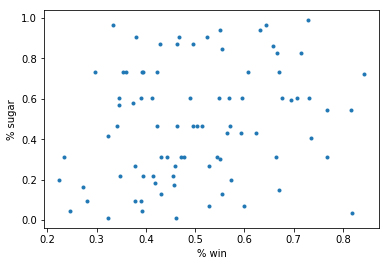

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(df['winpercent']/100, df['sugarpercent'], '.')
ax.set_xlabel('% win')
ax.set_ylabel('% sugar')

If the two variables were independent, we would not see any trend in the cloud of points. On this plot, it is a bit hard to tell. Let's use pandas to compute a coefficient correlation.

Let's compute the Pearson's correlation coefficient between the relative number of sugar, and the number of wins

In [26]:
df_bis = pd.DataFrame({'win': df['winpercent']/100,'sugar': df['sugarpercent']}).dropna()
df_bis.corr()

,win,sugar
win,1.000000,0.229151
sugar,0.229151,1.000000


A correlation of ~0.22 seems to indicate a positive correlation between our two variables. In other words, the more sugar, the more wins (which is not very surprising!).

## Contingency Table

A categorical variable is a variable that may take on one of a set of labels. 


Now, to determine if there is a statistically significant correlation between the variables, we use a chi-squared test of the independence of categorical variables in a contingency table.

First, we binarize our variables. Here, the value corresponding to the sugar is True if there is more sugar than usual in a product, and False otherwise:

In [27]:
df_bis['morewin'] = (df_bis['win'] > df_bis['win'].median())
df_bis['moresugar'] = (df_bis['sugar'] > df_bis['sugar'].median())
df_bis.tail()

,win,sugar,morewin,moresugar
80,0.454663,0.220,False,False
81,0.390119,0.093,False,False
82,0.443755,0.313,False,False
83,0.419043,0.186,False,False
84,0.495241,0.872,True,True


We can summarize the collected observations in a table with one variable corresponding to columns and another variable corresponding to rows. Each cell in the table corresponds to the count or frequency of observations that correspond to the row and column categories.

Then, we create a contingency table, with the frequencies of all four possibilities (True and True, True and False, and so on):

In [28]:
ct=pd.crosstab(df_bis['morewin'], df_bis['moresugar'])
ct

moresugar,False,True
morewin,,
False,27,16
True,19,23


## Pearson’s Chi-Squared Test

The Chi-Squared test is a statistical hypothesis test that assumes (the null hypothesis) that the observed frequencies for a categorical variable match the expected frequencies for the categorical variable. The test calculates a statistic that has a chi-squared distribution.

The number of observations for a category (such as more or less then average sugar) may or may not be the same. Nevertheless, we can calculate the expected frequency of observations in each Interest group and see whether the partitioning of interests by Sex results in similar or different frequencies.

The Chi-Squared test does this for a contingency table, first calculating the expected frequencies for the groups, then determining whether the division of the groups, called the observed frequencies, matches the expected frequencies.

We can interpret the test statistic in the context of the chi-squared distribution with the requisite number of degress of freedom as follows:

- If Statistic >= Critical Value: significant result, reject null hypothesis (H0), dependent.
- If Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0), independent.

In terms of a p-value and a chosen significance level (alpha), the test can be interpreted as follows:

- If p-value <= alpha: significant result, reject null hypothesis (H0), dependent.
- If p-value > alpha: not significant result, fail to reject null hypothesis (H0), independent.

For the test to be effective, at least five observations are required in each cell of the contingency table.

Finally, we compute the chi-squared test statistic and the associated p-value. The null hypothesis is the independence between the variables. SciPy implements this test in scipy.stats.chi2_contingency():

In [29]:
import scipy.stats as st
stat, p, dof, expected = st.chi2_contingency(ct, correction=False)
print(stat, p, dof, expected)

2.636314786213675 0.10444556540994673 1 [[23.27058824 19.72941176]
 [22.72941176 19.27058824]]


The function takes an array as input representing the contingency table for the two categorical variables. It returns the calculated statistic and p-value for interpretation as well as the calculated degrees of freedom and table of expected frequencies.

We're interested in the second result, which is the p-value. The p-value is much lower than 0.05, so we reject the null hypothesis and conclude that there is a statistically significant correlation between the proportion of sugar and the proportion of wins in this dataset.

We can interpret the statistic by retrieving the critical value from the chi-squared distribution for the probability and number of degrees of freedom.

For example, a probability of 90% can be used, suggesting that the finding of the test is quite likely given the assumption of the test that the variable is independent. If the statistic is less than or equal to the critical value, we can fail to reject this assumption, otherwise it can be rejected.

In [30]:
prob = 0.95
critical = st.chi2.ppf(prob, dof)
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

Independent (fail to reject H0)


We can also interpret the p-value by comparing it to a chosen significance level, which would be 10%, calculated by inverting the 90% probability used in the critical value interpretation.

In [31]:
# interpret p-value
alpha = 1.0 - prob
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

Independent (fail to reject H0)


In [32]:
def get_reject(column_name,df,prob):
  win = "winpercent"
  df_bis = pd.DataFrame({'win': df[win]/100,'column': df[column_name]}).dropna()
  df_bis['morewin'] = (df_bis['win'] > df_bis['win'].median())
  df_bis['moreX'] = (df_bis['column'] > df_bis['column'].median())
  _,p,_,_=st.chi2_contingency(pd.crosstab(df_bis['morewin'], df_bis['moreX']))
  # interpret p-value
  alpha = 1.0 - prob
  if p <= alpha:
    return('Dependent (reject H0)')
  else:
    return('Independent (fail to reject H0)')
  
url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv'
df = pd.read_csv(url, index_col=0)

[{i : get_reject(i,df,prob)} for i in df.columns]

[{'chocolate': 'Dependent (reject H0)'},
 {'fruity': 'Dependent (reject H0)'},
 {'caramel': 'Independent (fail to reject H0)'},
 {'peanutyalmondy': 'Dependent (reject H0)'},
 {'nougat': 'Independent (fail to reject H0)'},
 {'crispedricewafer': 'Dependent (reject H0)'},
 {'hard': 'Dependent (reject H0)'},
 {'bar': 'Dependent (reject H0)'},
 {'pluribus': 'Independent (fail to reject H0)'},
 {'sugarpercent': 'Independent (fail to reject H0)'},
 {'pricepercent': 'Dependent (reject H0)'},
 {'winpercent': 'Dependent (reject H0)'}]